In [4]:
import json
import math
import affine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from osgeo import gdal,ogr,osr

In [ ]:
# This Python script reads a file and extracts metadata keys from it. 

#with open("D:\\ABoVE\\ang20180814t224053_rfl_v2r2\\ang20180814t224053_corr_v2r2_img.hdr","r") as f:
with open("D:\\ABoVE\\ang20190728t171711\\ang20190728t171711_rdn_v2v2\\ang20190728t171711_rdn_v2v2_img.hdr","r") as f:
    print("Metadata keys:\n"+", ".join(
        [ln.strip().split(" = ")[0] for ln in f.readlines() if " = " in ln]))

In [ ]:
# open the ENVI file
img = gdal.Open("D:\\ABoVE\\ang20190728t171711\\ang20190728t171711_rdn_v2v2\\ang20190728t171711_rdn_v2v2_img")

nbands = img.RasterCount
nrows = img.RasterYSize
ncols = img.RasterXSize

print("\n".join(["Bands:\t"+str(nbands),"Rows:\t"+str(nrows),"Cols:\t"+str(ncols)]))


# new March 17th 
# Create an output GeoTIFF file
output_tiff = "D:\\ABoVE\\OutputTIf\\ang20190728t171711_fulltiff.tif"
driver = gdal.GetDriverByName("GTiff")
output_dataset = driver.Create(output_tiff, ncols, nrows, nbands, gdal.GDT_Float32)

# Loop through each band and write it to the output GeoTIFF file
for i in range(1, nbands + 1):
    band = img.GetRasterBand(i)
    data = band.ReadAsArray()
    output_band = output_dataset.GetRasterBand(i)
    output_band.WriteArray(data)

# Set the geotransform and projection information
output_dataset.SetGeoTransform(img.GetGeoTransform())
output_dataset.SetProjection(img.GetProjection())

# Close the datasets
img = None
output_dataset = None

print("Exported all bands as a single GeoTIFF file:", output_tiff)

Bands:	425
Rows:	7012
Cols:	693


In [ ]:
# # Open the ENVI file
# img = gdal.Open("D:\\ABoVE\\ang20180814t224053_rfl_v2r2\\ang20180814t224053_corr_v2r2_img")

# # Specify the watershed shapefile
# watershed = "D:\\ABoVE\\Shapefile\\Watershed_NGEE_Arctic_Seward_Peninsula_Teller_20171211.shp"

# # Open the watershed shapefile
# shp = ogr.Open(watershed)
# lyr = shp.GetLayer()  # Get the layer from the shapefile

# # Get the raster dimensions
# nbands = img.RasterCount
# nrows = img.RasterYSize
# ncols = img.RasterXSize

# # Print raster dimensions
# print("\n".join(["Bands:\t"+str(nbands), "Rows:\t"+str(nrows), "Cols:\t"+str(ncols)]))

# # Perform the clipping
# clipped_raster_path = "D:\\ABoVE\\OutputTIf\\clipped_raster_TEST1.tif"  # Output path for clipped raster
# clipped_raster = gdal.Warp(clipped_raster_path, img, cutlineDSName=watershed, cropToCutline=True)

# # Check the dimensions of the clipped raster
# clipped_nrows = clipped_raster.RasterYSize
# clipped_ncols = clipped_raster.RasterXSize

# # Print clipped raster dimensions
# print("\nClipped Raster Dimensions:")
# print("\n".join(["Rows:\t"+str(clipped_nrows), "Cols:\t"+str(clipped_ncols)]))


In [ ]:
# band descriptions. we reference this dictionary throughout the tutorial.
band_dictionary = {
    "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
    "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
}

# function to classify bands
between = lambda wavelength, region: region['lower'] < wavelength <= region['upper']
def classifier(band):
    for region, limits in band_dictionary.items():
        if between(band, limits):
            return(region)

# lists of band numbers, band centers, and em classes
band_numbers = [int(b.split("_")[1]) for b in img.GetMetadata().keys() if b != "wavelength_units"]
band_centers = [float(b.split(" ")[0]) for b in img.GetMetadata().values() if b != "Nanometers"]
em_regions = [classifier(b) for b in band_centers]

# data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band center (nm)": band_centers, 
    "EM region": em_regions }, index = band_numbers).sort_index()

# print the first ten rows
bands

In [ ]:
#
#sites = "D:\\ABoVE\\Shapefile\\TL_Permafrost_Monitoring.shp"
sites = "D:\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_pt.shp"

# open with ogr
driver = ogr.GetDriverByName("ESRI Shapefile")
permafrost_sites = driver.Open(sites, 0)

# get the first feature in the shapefile as JSON
site1 = json.loads(permafrost_sites[0].GetFeature(0).ExportToJson())
site1

In [ ]:
# import geopandas as gpd
# import matplotlib.pyplot as plt

# # Read the shapefile
# permafrost_sites = gpd.read_file("D:\\ABoVE\\Shapefile\\TL_Permafrost_Monitoring.shp")

# # Plot the sites
# permafrost_sites.plot()
# plt.title("Permafrost Monitoring Sites")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()



In [ ]:
print("ENVI image WKT: \n"+str(img.GetProjectionRef()))
print("\nShapefile WKT: \n"+str(permafrost_sites[0].GetSpatialRef()))

In [ ]:
# from osgeo import ogr, osr
# import affine
# shapefiles have a nested structure: layer(s) -> feature(s) -> geometry
lyr = permafrost_sites.GetLayer() # get the only layer in the shapefile
feat = lyr.GetFeature(1)          # get the first feature in the layer (1 feature per site)
geom = feat.GetGeometryRef()      # get the feature's geometry

# get transform for decimal degrees
from_srs = lyr.GetSpatialRef()                                         # get shapefile srs def
to_srs = osr.SpatialReference()                                        # init ogr srs object
to_srs.ImportFromEPSG(4326)                                            # import wgs84 srs def
xytransform = osr.CoordinateTransformation(from_srs,to_srs)            # get transform object
#xytransform = osr.CoordinateTransformation(to_srs)            # get transform object

# get UTM and lat/long coordinates for each of the sites
utm_coordinate_pairs = {}
ll_coordinate_pairs = {}
for feature in lyr:
    geom = feature.GetGeometryRef()                                    # get site geometry
    utm_coordinate_pairs[feature['Name']] = (geom.GetX(), geom.GetY()) # get x,y utm coordinates 
    geom.Transform(xytransform)                                        # to wgs84
    ll_coordinate_pairs[feature['Name']] = (geom.GetX(), geom.GetY())  # get lon, lat
    
# get the x and y UTM coordinates for the first site
#x, y = utm_coordinate_pairs['TL_IS_2']
x, y = utm_coordinate_pairs['1']
#x, y = utm_coordinate_pairs['Alder']

affine_transform = affine.Affine.from_gdal(*img.GetGeoTransform())     # affine forward transform
inverse_transform = ~affine_transform                                  # invert transform
px, py = inverse_transform * (x, y)                                    # apply to x,y coordinates
px, py = int(px + 0.5), int(py + 0.5)                                  # get new x,y as integers

# print the three coordinates (UTM, geographic, image)
print( "\n".join(["Site 1 UTM coordinates (x,y): "+"\t"*4+str((x,y)),
       " are equal to geographic coordinates (lng,lat): \t"+str(ll_coordinate_pairs['1']),
       " and fall within image coordinates (pixel,line):\t"+str((px,py))]) )

In [ ]:
# get image coordinates for each site
image_coordinate_pairs = {
    site: inverse_transform * pair for site,pair in utm_coordinate_pairs.items()}

print("site id: (col, row)")
for site,coord in image_coordinate_pairs.items():  # must convert to int to raster array  
    print(site + ": (" + str(int(coord[0] + 0.5)) + ", " + str(int(coord[1] + 0.5)) +")")

In [ ]:
site1name = list(image_coordinate_pairs.keys())[0]    # get name of site1
site1xy = list(image_coordinate_pairs.values())[0]    # get image coordinates of site1
px, py = int(site1xy[0] + 0.5), int(site1xy[1] + 0.5) # convert image coordinates to integers

band1_array = img.GetRasterBand(1).ReadAsArray()
print("Band 1 reflectance at site 1: "+str(band1_array[py,px]))

In [ ]:
# function gets value at input xy from input band
get_pixel = lambda img,band,y,x: img.GetRasterBand(band).ReadAsArray()[y,x]

# make a copy of the bands data frame and add reflectance column for site 1
_bands = bands
_bands[site1name+" reflectance"] = [get_pixel(img,b,py,px) for b in range(1,nbands+1)]
_bands.head(10)

In [ ]:
site2name = list(image_coordinate_pairs.keys())[1]    # get name of site1
site2xy = list(image_coordinate_pairs.values())[1]    # get image coordinates of site1
px, py = int(site2xy[0] + 0.5), int(site2xy[1] + 0.5) # convert image coordinates to int

_bands[site2name+" reflectance"] = [get_pixel(img,b,py,px) for b in range(1,nbands+1)]
_bands.head(10)

In [ ]:
from tqdm import tqdm  # Import tqdm

# Read all bands data at once
band_data = [img.GetRasterBand(b).ReadAsArray() for b in range(1, nbands+1)]

# Now you can access the pixel value directly from the array in memory without reading from file
get_pixel = lambda band_data, b, y, x: band_data[b-1][y, x]

# Assuming 'bands' is a DataFrame and you want to add a new column for reflectance
# You can now use the get_pixel function with pre-loaded band_data
# Wrap range(1, nbands+1) with tqdm for a progress bar
bands[site1name + " reflectance"] = [get_pixel(band_data, b, py, px) for b in tqdm(range(1, nbands+1), desc="Processing bands")]


In [ ]:
# a ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function finds band in our table with wavelength nearest to input r,g,b wavelengths
get_band_number = lambda w: bands.iloc[(bands["Band center (nm)"]-w).abs().argsort()[1]]

# get band numbers. use R: 667.5nm, G: 540nm, B: 470nm
Ri, Gi, Bi = get_band_number(667.5), get_band_number(540), get_band_number(470)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(Ri),str(Gi),str(Bi)]))

# b ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function gets numpy array from input band
get_band = lambda b: img.GetRasterBand(int(b["Band number"])).ReadAsArray()

# get r,g,b arrays
Ra, Ga, Ba = get_band(Ri), get_band(Gi), get_band(Bi)

# set fill values (-9999.) to 0 for each array
Ra[Ra == -9999.], Ga[Ga == -9999.], Ba[Ba == -9999.] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
Ra8, Ga8, Ba8 = scale8bit(Ra), scale8bit(Ga), scale8bit(Ba)

# set rescaled fill pixels back to 0 for each array
Ra8[Ra == 0], Ga8[Ga == 0], Ba8[Ba == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = Ra8, Ga8, Ba8

# print shape of raster stack
print("---"*20+"\nRGB stack (rows,cols,bands): " + str(rgb_stack.shape))

In [ ]:
# get the raster geotransform as its component parts
xmin, xres, xrot, ymax, yrot, yres = img.GetGeoTransform()

# generate coordinate arrays
xarr = np.array([int(xmin+i*xres) for i in range(0,ncols)])
yarr = np.array([int(ymax+i*yres) for i in range(0,nrows)])

print("the first 10 x coordinates:")
xarr[:10]

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': Ra8, 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': Ga8, 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': Ba8, 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim,
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20)#, fontdict = titlefont)  
    

   
#plt.savefig("D:\\ABoVE\\Figures\\rbg_plot_StudySite.png", dpi=300, bbox_inches='tight')


plt.imshow(rgb_stack, extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])

In [ ]:
# apply histogram equalization to each band
for i in range(rgb_stack.shape[2]):

    # band i
    b = rgb_stack[:,:,i]
    
    # histogram from flattened (1d) image
    b_histogram, bins = np.histogram(b.flatten(), 256)

    # cumulative distribution function
    b_cumdistfunc = b_histogram.cumsum()

    # normalize
    b_cumdistfunc = 255 * b_cumdistfunc / b_cumdistfunc[-1]

    # get new values by linear interpolation of cdf
    b_equalized = np.interp(b.flatten(), bins[:-1], b_cumdistfunc)
    
    # reshape to 2d and add back to rgb_stack
    rgb_stack[:,:,i] = b_equalized.reshape(b.shape)
    
    
# plot. all of this is matplotlib ---------->
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': rgb_stack[:,:,0], 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': rgb_stack[:,:,1], 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': rgb_stack[:,:,2], 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim,
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20)#, fontdict = titlefont)
    
#plt.savefig("D:\\ABoVE\\Figures\\rbg_plot_StudySite_HistEqualized.png", dpi=300, bbox_inches='tight')

plt.imshow(rgb_stack)

In [ ]:
# find bands nearest to NDVI red and nir wavelengths
ndvi_red, ndvi_nir = get_band_number(685), get_band_number(900)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(ndvi_red),str(ndvi_nir)]))

# get the numpy arrays for the two bands
R685, R900 = get_band(ndvi_red), get_band(ndvi_nir)

# set fill value to numpy nan for all -9999.
R685[R685 == -9999.], R900[R900 == -9999.] = np.nan, np.nan

# calculate ndvi
ndvi_array = (R900-R685)/(R900+R685)

# print ndvi statistics
print(str("---"*20+"\n")+", ".join([
    "NDVI stats --- mean: "+str(np.nanmean(ndvi_array)), 
    "std: "+str(np.nanstd(ndvi_array)), 
    "min: "+str(np.nanmin(ndvi_array)), 
    "max: "+str(np.nanmax(ndvi_array)) 
]))

In [ ]:
# get sr bands
R750, R705 = get_band(get_band_number(750)), get_band(get_band_number(705))
# set fill value to numpy nan for all -9999.
R705[R705 == -9999.], R750[R750 == -9999.] = np.nan, np.nan
# calculate sr
sr_array = R750/R705

# calculate savi
savi_array = 0.5*(R900-R685)/(R900+R685+0.5)

# plot. all of this is matplotlib ---------->
gs = gridspec.GridSpec(1, 3)

plotdict1 = { 'NDVI\n(R900-R685)/(R900+R685)': { 'subplot': 0, 'array': ndvi_array },
             'SR\nR750/R705': { 'subplot': 1, 'array': sr_array },
             'SAVI\nL*(R900-R685)/(R900+R685+L)': { 'subplot': 2, 'array': savi_array } }

# initialize plot and add ax element for each array in plotdict
fig2 = plt.figure()
for band,data in plotdict1.items():
    ax = fig2.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=plt.get_cmap("RdYlGn"),
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20)#, fontdict = titlefont)
    plt.colorbar(p)

# Exporting Spectral Index Arrays to GeoTIFF with GDAL 

In [ ]:
# WORKS - this export each single band ratio (NDVI, SR, SAVI) in arrays

# Assuming 'img' is your source raster and the arrays are already computed
arrays = {
    "ndvi": ndvi_array,
    "sr": sr_array,
    "savi": savi_array
}

output_path = "D:\\ABoVE\\OutputTIf\\"
file_suffix = "_ang20190728t171711_rdn_v2v2_img.tif"

# Set geotransform and projection from the source image
geo = img.GetGeoTransform()
wkt = img.GetProjection()

for key, array in arrays.items():
    # Replace NaN with no-data value
    array[np.isnan(array)] = -9999.

    # Create the output file path
    output_file = f"{output_path}{key}{file_suffix}"

    # Open GDAL raster dataset for writing
    outraster = gdal.GetDriverByName('GTiff').Create(
        output_file, 
        img.RasterXSize, 
        img.RasterYSize, 
        1, 
        gdal.GDT_Float32
    )

    # Set geotransform and projection
    outraster.SetGeoTransform(geo)
    outraster.SetProjection(wkt)

    # Get the first band and write the array
    outraster_band = outraster.GetRasterBand(1)
    outraster_band.WriteArray(array)
    outraster_band.SetNoDataValue(-9999)

    # Write out and close the file
    outraster.FlushCache()
    outraster = None

print("Done!")


# CLIP indicies to study site 

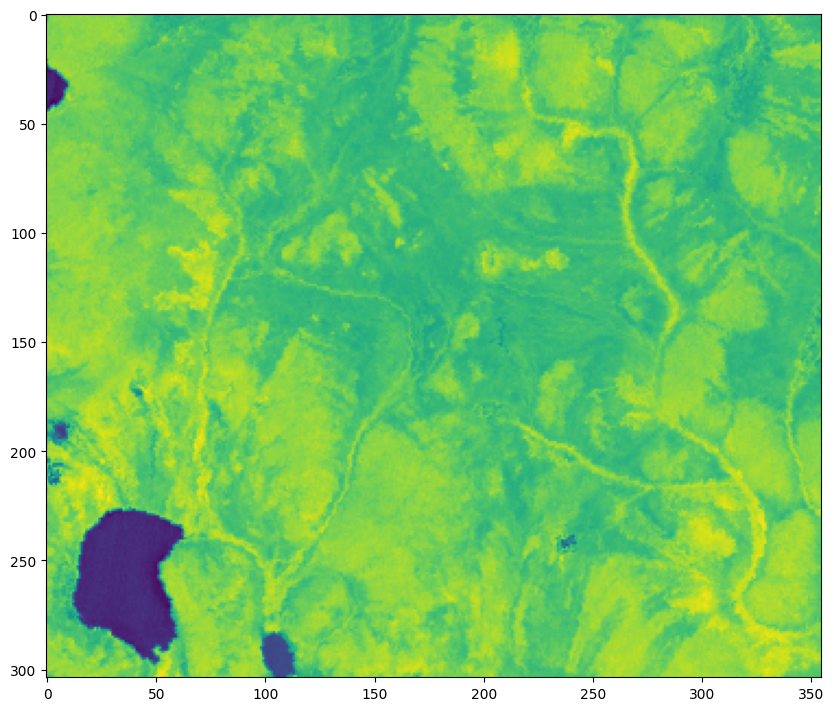

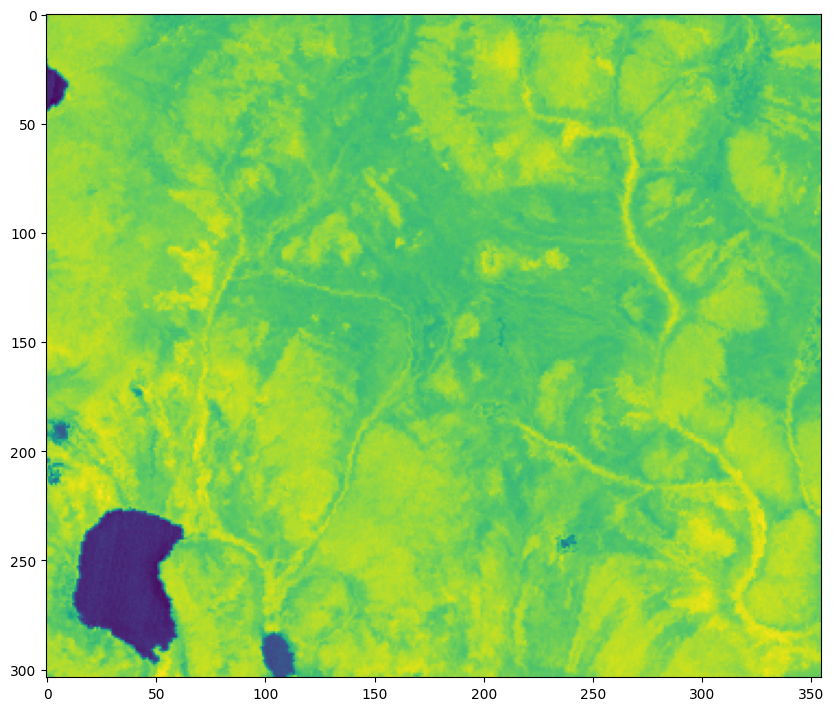

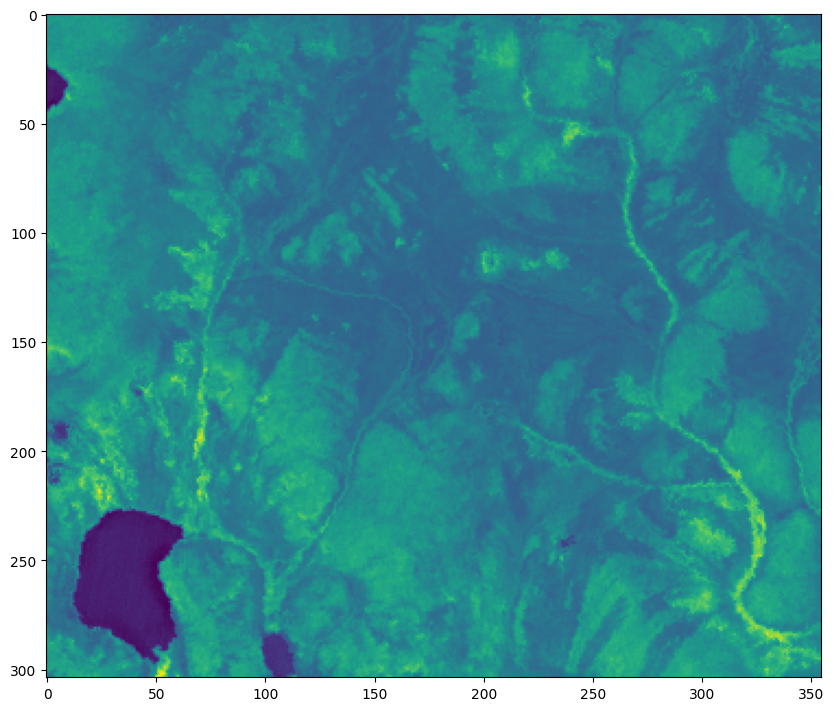

In [2]:
import os
from osgeo import ogr, gdal
import numpy as np
import matplotlib.pyplot as plt

extent = "D:\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_SquareBuffer.shp"

# Open shapefile
shp = ogr.Open(extent)
lyr = shp.GetLayer()

# List of input GeoTIFF files
input_files = [
    "D:\\ABoVE\\OutputTIf\\savi_ang20190728t171711_rdn_v2v2_img.tif",
    "D:\\ABoVE\\OutputTIf\\ndvi_ang20190728t171711_rdn_v2v2_img.tif",
    "D:\\ABoVE\\OutputTIf\\sr_ang20190728t171711_rdn_v2v2_img.tif"
]

# Loop through input files
for input_file in input_files:
    # Output file name
    output_file = os.path.splitext(input_file)[0] + "_CLIPPED.tif"

    # Perform clipping
    outraster = gdal.Warp(
        output_file,
        input_file,
        format='GTiff',
        cutlineDSName=extent,
        cutlineLayer=lyr.GetName(),
        cropToCutline=True,
        dstNodata=-9999
    )

    # Plot the clipped image
    plt.rcParams['figure.figsize'] = [10, 10]
    clipped_img = outraster.GetRasterBand(1).ReadAsArray()
    clipped_img[clipped_img == -9999.] = np.nan
    plt.imshow(clipped_img)
    plt.show()


# To WGS84

In [11]:
import os
from osgeo import ogr, gdal, osr
import numpy as np
import matplotlib.pyplot as plt

watershed = "D:\\ABoVE\\Shapefile\\Watershed_NGEE_Arctic_Seward_Peninsula_Teller_20171211.shp"
extent = "D:\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_SquareBuffer.shp"

# Open shapefile
shp = ogr.Open(watershed)
lyr = shp.GetLayer()

# List of input GeoTIFF files
input_files = [
    "D:\\ABoVE\\OutputTIf\\savi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif",
    "D:\\ABoVE\\OutputTIf\\ndvi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif",
    "D:\\ABoVE\\OutputTIf\\sr_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif"
]

# Loop through input files
for input_file in input_files:
    # Output file name
    output_file = os.path.splitext(input_file)[0] + "_wgs.tif"

    # Open the clipped image
    img = gdal.Open(input_file)

    # Initialize OSR spatial reference object for WGS84
    outsrs = osr.SpatialReference()
    outsrs.ImportFromEPSG(4326)
    
    # Get the projection
    wkt = img.GetProjection()

    # Create virtual warped raster
    warp = gdal.AutoCreateWarpedVRT(
        img,
        wkt,
        outsrs.ExportToWkt(),
        gdal.GRA_NearestNeighbour,
        0.0
    )
    warpb = warp.GetRasterBand(1).ReadAsArray()

    # Create output raster dataset and write warped raster array
    outraster3 = gdal.GetDriverByName('GTiff').Create(
        output_file,
        warp.RasterXSize,
        warp.RasterYSize,
        1,
        gdal.GDT_Float32
    )

    outraster3.SetGeoTransform(warp.GetGeoTransform())
    outraster3.SetProjection(warp.GetProjection())
    outraster3b = outraster3.GetRasterBand(1)
    outraster3b.WriteArray(warpb)
    outraster3b.SetNoDataValue(-9999)
    outraster3.FlushCache()

    # Close open files
    img = None
    outraster3 = None
    warp = None


# Extract data and put into df

In [18]:
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd

# Read the raster file
raster_path = r"D:\ABoVE\OutputTIf\savi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif"
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read()
    # Get the profile of the raster
    raster_profile = src.profile
    # Get the CRS of the raster
    raster_crs = src.crs

# Read the shapefile
shapefile_path = r"D:\ABoVE\Shapefile\SquareVegPlots_within_ang20190728t171711_pt.shp"
gdf = gpd.read_file(shapefile_path)

# Reproject the shapefile to the CRS of the raster
gdf_reprojected = gdf.to_crs(raster_crs)

# Create an empty DataFrame to store the results
df = pd.DataFrame(columns=gdf.columns.tolist() + ['savi'])

# Extract information from the raster
with rasterio.open(raster_path) as src:
    for index, row in gdf_reprojected.iterrows():
        # Get the coordinates of the centroid of the polygon
        centroid = row['geometry'].centroid
        lon, lat = centroid.x, centroid.y
        # Get the pixel coordinates of the centroid
        px, py = src.index(lon, lat)
        # Get the pixel values at the centroid
        pixel_value = src.read(1, window=((py, py+1), (px, px+1)))
        # Add the pixel value to the DataFrame
        df.loc[index] = row.tolist() + [pixel_value.item()]

df


,Name,FolderPath,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,Shape_Leng,Shape_Area,ORIG_FID,geometry,savi
0,1,SquareVegPlots/SquareVegPlots,0,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.00202,1.992299e-07,0,POINT Z (560574.2874076627 7627306.075519014 0),0.196186
1,2,SquareVegPlots/SquareVegPlots,1,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.00202,1.992260e-07,1,POINT Z (560507.4123065518 7627248.772151392 0),0.235608
2,4,SquareVegPlots/SquareVegPlots,0,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.00202,1.992244e-07,2,POINT Z (560677.626355797 7627224.289890654 0),0.254260
3,5,SquareVegPlots/SquareVegPlots,0,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.00202,1.992062e-07,3,POINT Z (560551.300799421 7627000.371686019 0),0.232145
4,6,SquareVegPlots/SquareVegPlots,2,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.00202,1.992198e-07,4,POINT Z (560849.5457997443 7627171.874240555 0),0.204676
5,7,SquareVegPlots/SquareVegPlots,0,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.00202,1.992055e-07,5,POINT Z (560697.4640367143 7627006.5587629415 0),0.243939
6,8,SquareVegPlots/SquareVegPlots,1,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.00202,1.992178e-07,6,POINT Z (560951.2240518155 7627158.100719389 0),0.241469
7,9,SquareVegPlots/SquareVegPlots,3,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.00202,1.992105e-07,7,POINT Z (560285.1383978231 7627060.657887269 0),0.186633
8,10,SquareVegPlots/SquareVegPlots,3,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.00202,1.992259e-07,8,POINT Z (560795.2491514711 7627258.112066966 0),0.215376
9,11,SquareVegPlots/SquareVegPlots,4,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.00202,1.992101e-07,9,POINT Z (560470.9929619869 7627058.925565124 0),0.238638


In [13]:
# #"D:\ABoVE\Shapefile\TL_Permafrost_Monitoring.shp"

# #"D:\ABoVE\OutputTIf\saviExample_clipped_wgs84.tif"

# import geopandas as gpd
# import rasterio
# from rasterio.warp import calculate_default_transform, reproject, Resampling

# # Read the raster file
# raster_path = r"D:\ABoVE\OutputTIf\savi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif"
# with rasterio.open(raster_path) as src:
#     # Read the raster data
#     raster_data = src.read()
#     # Get the profile of the raster
#     raster_profile = src.profile
#     # Get the CRS of the raster
#     raster_crs = src.crs

# # Read the shapefile
# shapefile_path = r"D:\ABoVE\Shapefile\SquareVegPlots_within_ang20190728t171711_pt.shp"
# gdf = gpd.read_file(shapefile_path)

# # Reproject the shapefile to the CRS of the raster
# gdf_reprojected = gdf.to_crs(raster_crs)

# # Extract information from the raster
# # For example, getting pixel values at the centroid of each polygon
# with rasterio.open(raster_path) as src:
#     for index, row in gdf_reprojected.iterrows():
#         # Get the coordinates of the centroid of the polygon
#         centroid = row['geometry'].centroid
#         lon, lat = centroid.x, centroid.y
#         # Get the pixel coordinates of the centroid
#         px, py = src.index(lon, lat)
#         # Get the pixel values at the centroid
#         pixel_value = src.read(1, window=((py, py+1), (px, px+1)))
#         print("Pixel value at centroid:", pixel_value)

# # Additional processing or analysis can be performed here based on the extracted information


Pixel value at centroid: [[0.19618563]]
Pixel value at centroid: [[0.23560792]]
Pixel value at centroid: [[0.25425985]]
Pixel value at centroid: [[0.2321445]]
Pixel value at centroid: [[0.20467591]]
Pixel value at centroid: [[0.24393858]]
Pixel value at centroid: [[0.24146897]]
Pixel value at centroid: [[0.1866333]]
Pixel value at centroid: [[0.21537648]]
Pixel value at centroid: [[0.2386376]]
Pixel value at centroid: [[-0.08047903]]
Pixel value at centroid: [[0.24458775]]
Pixel value at centroid: [[0.2688507]]
Pixel value at centroid: [[0.2427693]]
Pixel value at centroid: [[0.15757652]]
Pixel value at centroid: [[0.25095266]]
Pixel value at centroid: [[0.18764405]]
Pixel value at centroid: [[0.20026371]]
Pixel value at centroid: [[0.21040396]]
Pixel value at centroid: [[0.23499252]]
Pixel value at centroid: [[0.25420555]]
Pixel value at centroid: [[0.23483281]]
Pixel value at centroid: [[0.16376211]]
Pixel value at centroid: [[0.2644573]]
Pixel value at centroid: [[0.23710759]]
Pixel

# Old Code

In [ ]:
#This is export single band ratios for independent - not clean

# # open gdal raster dataset for writing
# outraster1 = gdal.GetDriverByName('GTiff').Create(
#     "D:\\ABoVE\\OutputTIf\\ndvi_ang20190728t171711_rdn_v2v2_img.tif",                                     # output GeoTIFF
#     img.RasterXSize,                                # number of columns
#     img.RasterYSize,                                # number of rows
#     1 ,                                             # number of bands
#     gdal.GDT_Float32)                               # data type

# # set geotransform and projection information
# geo = img.GetGeoTransform()                         # get geotransform from input raster
# outraster1.SetGeoTransform(geo)                     # set geotransform
# wkt = img.GetProjection()                           # get projection from input raster
# outraster1.SetProjection(wkt)                       # set projection 

# # get band 1
# outraster1b = outraster1.GetRasterBand(1)           # get band 1 of output

# # write to band 1
# ndvi_array[np.isnan(ndvi_array)] = -9999.           # fill np.nan in savi array with -9999.0
# outraster1b.WriteArray(ndvi_array)                  # write savi array to band 1;
# outraster1b.SetNoDataValue(-9999)                   # set nodata value to -9999

# outraster1.FlushCache()                             # write out
# outraster1 = None        # close the file


# outraster1 = gdal.GetDriverByName('GTiff').Create(
#     "D:\\ABoVE\\OutputTIf\\sr_ang20190728t171711_rdn_v2v2_img.tif",                                     # output GeoTIFF
#     img.RasterXSize,                                # number of columns
#     img.RasterYSize,                                # number of rows
#     1 ,                                             # number of bands
#     gdal.GDT_Float32)                               # data type

# # set geotransform and projection information
# geo = img.GetGeoTransform()                         # get geotransform from input raster
# outraster1.SetGeoTransform(geo)                     # set geotransform
# wkt = img.GetProjection()                           # get projection from input raster
# outraster1.SetProjection(wkt)                       # set projection 

# # get band 1
# outraster1b = outraster1.GetRasterBand(1)           # get band 1 of output

# # write to band 1
# sr_array[np.isnan(sr_array)] = -9999.           # fill np.nan in savi array with -9999.0
# outraster1b.WriteArray(sr_array)                  # write savi array to band 1;
# outraster1b.SetNoDataValue(-9999)                   # set nodata value to -9999

# outraster1.FlushCache()                             # write out
# outraster1 = None 



# # open gdal raster dataset for writing
# outraster1 = gdal.GetDriverByName('GTiff').Create(
#     "D:\\ABoVE\\OutputTIf\\savi_ang20190728t171711_rdn_v2v2_img.tif",                                     # output GeoTIFF
#     img.RasterXSize,                                # number of columns
#     img.RasterYSize,                                # number of rows
#     1 ,                                             # number of bands
#     gdal.GDT_Float32)                               # data type

# # set geotransform and projection information
# geo = img.GetGeoTransform()                         # get geotransform from input raster
# outraster1.SetGeoTransform(geo)                     # set geotransform
# wkt = img.GetProjection()                           # get projection from input raster
# outraster1.SetProjection(wkt)                       # set projection 

# # get band 1
# outraster1b = outraster1.GetRasterBand(1)           # get band 1 of output

# # write to band 1
# savi_array[np.isnan(savi_array)] = -9999.           # fill np.nan in savi array with -9999.0
# outraster1b.WriteArray(savi_array)                  # write savi array to band 1;
# outraster1b.SetNoDataValue(-9999)                   # set nodata value to -9999

# outraster1.FlushCache()                             # write out
# outraster1 = None 


# print("done!")

In [ ]:
# nOT WORKing
# from osgeo import gdal, osr

# # Open GDAL raster dataset for writing
# outraster = gdal.GetDriverByName('GTiff').Create(
#     "D:\\ABoVE\\OutputTIf\\saviExample_allbands3.tif",  # output GeoTIFF
#     img.RasterXSize,  # number of columns
#     img.RasterYSize,  # number of rows
#     img.RasterCount,  # number of bands
#     gdal.GDT_Float32)  # data type

# # Set geotransform and projection information
# geo = img.GetGeoTransform()  # get geotransform from input raster
# outraster.SetGeoTransform(geo)  # set geotransform
# wkt = img.GetProjection()  # get projection from input raster
# outraster.SetProjection(wkt)  # set projection

# # Loop through each band
# for i in range(1, img.RasterCount + 1):
#     print(i)
#     # Get band
#     band = img.GetRasterBand(i)
#     band_array = band.ReadAsArray()

#     # Write to band
#     band_out = outraster.GetRasterBand(i)
#     band_out.WriteArray(band_array)

#     # Set nodata value
#     band_out.SetNoDataValue(-9999)

# # Flush cache and close the file
# outraster.FlushCache()
# outraster = None
# print("done")

In [ ]:
# # Single CLIPPING works
# #watershed="D:\\ABoVE\\Shapefile\\Watershed_NGEE_Arctic_Seward_Peninsula_Teller_20171211.shp"

# extent="D:\ABoVE\Shapefile\SquareVegPlots_within_ang20190728t171711_SquareBuffer.shp"




# shp = ogr.Open(watershed)                                  # open shapefile
# lyr = shp.GetLayer()                                       # get first (and only) layer

# outraster2 = gdal.Warp(
#     "D:\\ABoVE\\OutputTIf\\savi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif",                                    # output GeoTIFF
#     "D:\\ABoVE\\OutputTIf\\savi_ang20190728t171711_rdn_v2v2_img.tif",                                            # input GeoTIFF
#     format = 'GTiff',                                      # output format
#     cutlineDSName = extent,                             # input masking/clipping shapefile
#     cutlineLayer = lyr.GetName(),                          # name of masking/clipping layer
#     cropToCutline = True,                                  # reduce to nodata inner ext
#     dstNodata = -9999)                                     # output raster nodata value 

# # plot it
# plt.rcParams['figure.figsize'] = [10, 10]                  # set dimensions of rendered plot
# clipped_savi = outraster2.GetRasterBand(1).ReadAsArray()   # get array from the output raster
# clipped_savi[clipped_savi == -9999.] = np.nan              # set -9999. back to numpy nan
# plt.imshow(clipped_savi)   

In [ ]:
# outsrs = osr.SpatialReference()                             # init osr srs object
# outsrs.ImportFromEPSG(4326)                                 # import WGS84 srs definitions
# wkt = img.GetProjection()

# # create virtual warped raster
# warp = gdal.AutoCreateWarpedVRT(
#     "D:\\ABoVE\\OutputTIf\\ndvi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif",                                             # source raster 
#     wkt,                                                    # source raster well-known text
#     outsrs.ExportToWkt())                                   # output raster well-known text
# warpb = warp.GetRasterBand(1).ReadAsArray()                 # warped raster band

# # create output raster dataset; write warped raster array
# outraster3 = gdal.GetDriverByName('GTiff').Create(
#     "D:\\ABoVE\\OutputTIf\\ndvi_ang20190728t171711_rdn_v2v2_img_CLIPPED_wgs.tif",                               # name of output tif
#     warp.RasterXSize,                                       # warped raster ncols
#     warp.RasterYSize,                                       # warped raster nrows
#     1,                                                      # warped raster nbands
#     gdal.GDT_Float32)                                       # data type

# outraster3.SetGeoTransform(warp.GetGeoTransform())          # set output geotransform
# outraster3.SetProjection(warp.GetProjection())              # set output projection
# outraster3b = outraster3.GetRasterBand(1)                   # get band 1
# outraster3b.WriteArray(warpb)                               # add band values
# outraster3b.SetNoDataValue(-9999)                           # set output nodata
# outraster3.FlushCache()                                     # write output

# # close all open files
# img = None
# outraster2 = None
# outraster3 = None
# warp = None